# Import


In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
from scipy import stats


# Emotion Data Preprocessing Utilities


In [3]:
def convert_date(date_str):
    try:
        date_obj = datetime.strptime(str(date_str), '%a %b %d %H:%M:%S %z %Y')
        return date_obj.strftime('%Y-%m-%d %H:%M:%S')
    except (ValueError, TypeError):
        return np.nan
    
def convert_date_df(df):
    df['date'] = df['created_at'].apply(convert_date)
    df = df.dropna(subset=['date'])
    df['date'] = pd.to_datetime(df['date'])

    # Create 'year' and 'month' columns
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    return df


def filter_emotion(df):
    cols = ['screen_name', 'joy_pys', 'sadness_pys', 'anger_pys', 
            'surprise_pys', 'disgust_pys', 'fear_pys', 'date']
    df = df[cols]
    df['date'] = pd.to_datetime(df['date'])
    return df

def filter_emotion_all(df):
  cols = ['screen_name', 'joy', 'sadness', 'anger', 
            'surprise', 'disgust', 'fear', 'date']
    df = df[cols]
    df['date'] = pd.to_datetime(df['date'])
    return df
def avg_emotion_per_user(df):
    df.loc[:, 'date'] = pd.to_datetime(df['date'])

    df.set_index('date', inplace=True)
    weekly_avg_per_user = df.groupby('screen_name').resample('M').mean()#w
    overall_weekly_avg = weekly_avg_per_user.groupby(level='date').mean()

    return overall_weekly_avg


def replace_column_emotion(df):
    df.columns = df.columns.str.replace('_pys', '', regex=False)
    return df


# --- Load and Process HCP Data ---

In [ ]:


# --- Load and Process HCP Data ---

# Load HCP tweets from job1
hcp_path = '///home/noaai/HCP_State_of_Mind_covid_19/pysentimento_tweets_transformer_and_optim/new/job1_tweets_emotion_pysentimento.csv'
HPS = pd.read_csv(hcp_path)

# Apply date conversion, emotion filtering, and column renaming
HPS = convert_date_df(HPS)
HPS = filter_emotion(HPS)
HPS = replace_column_emotion(HPS)

# Load list of active HCP users (screen names)
unique_screen_names = pd.read_csv('../active_h_90.csv')['screen_name'].tolist()

# Filter HCP data to include only active users
final_h = HPS[HPS['screen_name'].isin(unique_screen_names)]

# --- Load and Combine General Population Data ---

# Define list of files and directory path
file_names = [
    'job1_tweets_emotion_pysentimento.csv',
    'job2_tweets_emotion_pysentimento.csv',
    'job3_tweets_emotion_pysentimento.csv',
    'job4_tweets_emotion_pysentimento.csv',
    'job5_tweets_emotion_pysentimento.csv',
    'job6_tweets_emotion_pysentimento.csv',
    'job7_tweets_emotion_pysentimento.csv',
    'job8_tweets_emotion_pysentimento.csv',
    'job9_tweets_emotion_pysentimento.csv',
    'job10_tweets_emotion_pysentimento.csv',
    'job11_tweets_emotion_pysentimento.csv',
    'job12_tweets_emotion_pysentimento.csv',
    'job13_tweets_emotion_pysentimento.csv',
    'job18_tweets_emotion_pysentimento.csv',
]
output_folder = '/home/noaai/HCP_State_of_Mind_covid_19/new_code_for_artical/general_new/'

# Load and concatenate all general population CSVs
dfs = [pd.read_csv(f"{output_folder}{file}") for file in file_names]
combined_df = pd.concat(dfs, ignore_index=True)

general = convert_date_df(combined_df)
general = filter_emotion(general)
general = replace_column_emotion(general)


In [10]:
# Use the 'general' DataFrame as the base for general population data
final_df = general

# --- Ensure 'date' column is in datetime format and set as index ---

# For HCP data
final_h.loc[:, 'date'] = pd.to_datetime(final_h['date'])
final_h.set_index('date', inplace=True)

# For general population data
final_df.loc[:, 'date'] = pd.to_datetime(final_df['date'])
final_df.set_index('date', inplace=True)

# --- Compute monthly average emotions per user ---

hcp_avg_user = final_h.groupby('screen_name').resample('M').mean()
general_avg_user = final_df.groupby('screen_name').resample('M').mean()

# Reset index to return 'date' and 'screen_name' as columns
hcp_avg_user = hcp_avg_user.reset_index()
general_avg_user = general_avg_user.reset_index()

# --- Extract year and month for further grouping or plotting ---

general_avg_user['year'] = general_avg_user['date'].dt.year
general_avg_user['month'] = general_avg_user['date'].dt.month

hcp_avg_user['year'] = hcp_avg_user['date'].dt.year
hcp_avg_user['month'] = hcp_avg_user['date'].dt.month


In [14]:


def process_emotion_data(df):
    # Create a new column for counting unique users
    # df['user_count'] = df.groupby(['year', 'month'])['screen_name'].transform('nunique')

    # Group by year and month and calculate mean, standard deviation, and count of unique users
    grouped = df.groupby(['year', 'month']).agg({'joy': ['mean', 'std', 'count'],
                                                 'sadness': ['mean', 'std', 'count'],
                                                 'anger': ['mean', 'std', 'count'],
                                                 'surprise': ['mean', 'std', 'count'],
                                                 'disgust': ['mean', 'std', 'count'],
                                                 'fear': ['mean', 'std', 'count'],
                                                 'date': 'first'})

    # Calculate the 95% CI
    for emotion in ['joy', 'sadness', 'anger', 'surprise', 'disgust', 'fear']:
        count = grouped[(emotion, 'count')]
        grouped[(emotion, 'ci_lower')] = grouped[(emotion, 'mean')] - 1.96 * grouped[(emotion, 'std')] / np.sqrt(count)
        grouped[(emotion, 'ci_upper')] = grouped[(emotion, 'mean')] + 1.96 * grouped[(emotion, 'std')] / np.sqrt(count)

    # Flatten MultiIndex columns for better readability
    grouped.columns = ['_'.join(col).strip() for col in grouped.columns.values]
    
    return grouped

# Apply the function to both DataFrames
grouped_hcp = process_emotion_data(hcp_avg_user)
grouped_general = process_emotion_data(general_avg_user)


# Save Data

In [18]:
grouped_hcp.to_csv('Data_1/hcp_graph1.csv',encoding = 'utf-8')
grouped_general.to_csv('Data_1/nonhcp_graph1.csv',encoding = 'utf-8')

# load Data

In [26]:
grouped_hcp = pd.read_csv('Data_1/hcp_graph1.csv')
grouped_general = pd.read_csv('Data_1/nonhcp_graph1.csv')


In [27]:
import pickle

# Specify the filename for the pickle file
filename = '../significant_data.pkl'

# Open the file in read-binary mode and load the data
with open(filename, 'rb') as file:
    significant_data = pickle.load(file)



In [28]:
emotion_markers = significant_data

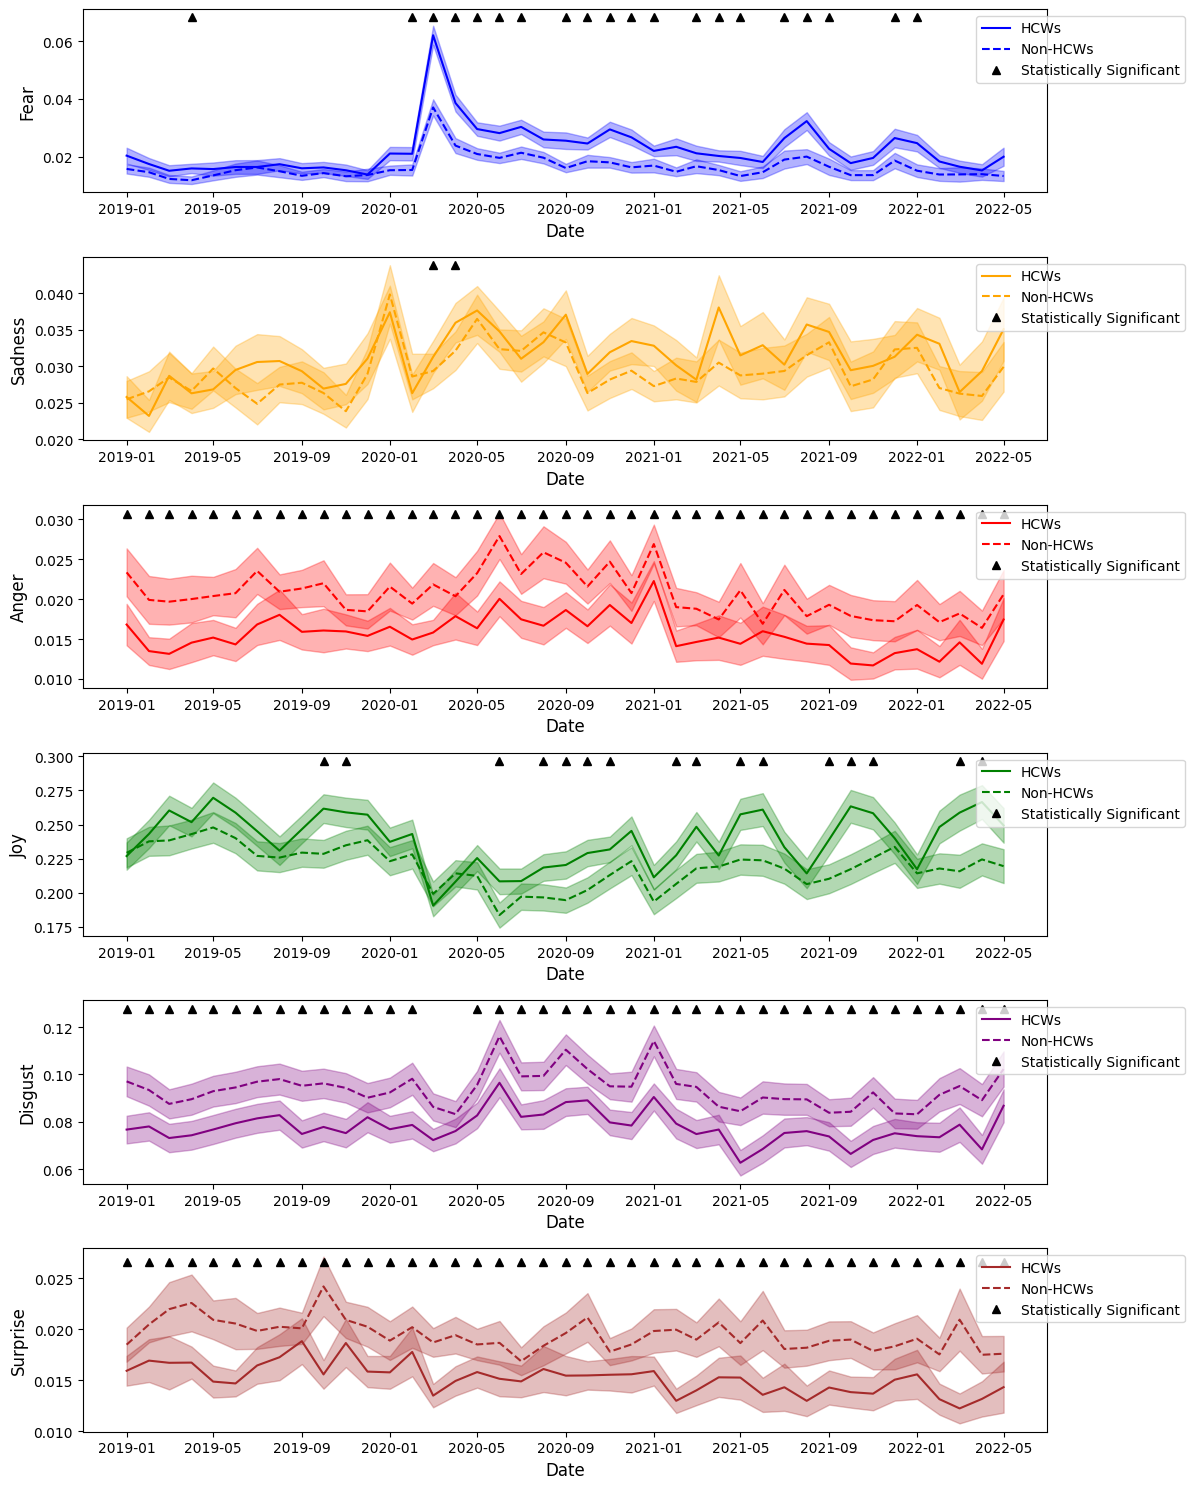

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')

# Define emotion order and corresponding colors
emotions = ['fear', 'sadness', 'anger', 'joy', 'disgust', 'surprise']
colors = ['blue', 'orange', 'red', 'green', 'purple', 'brown']

# Create figure with one subplot per emotion
fig, axs = plt.subplots(len(emotions), 1, figsize=(12, 2.5 * len(emotions)))

# Make sure 'date' column exists by combining year and month
grouped_hcp['date'] = pd.to_datetime(grouped_hcp['year'].astype(str) + '-' + grouped_hcp['month'].astype(str))
grouped_general['date'] = pd.to_datetime(grouped_general['year'].astype(str) + '-' + grouped_general['month'].astype(str))

for j, emotion in enumerate(emotions):
    ax = axs[j]

    # Extract mean and CI data
    hcp_mean = grouped_hcp[['date', f'{emotion}_mean', f'{emotion}_ci_lower', f'{emotion}_ci_upper']]
    general_mean = grouped_general[['date', f'{emotion}_mean', f'{emotion}_ci_lower', f'{emotion}_ci_upper']]

    # Plot confidence intervals as shaded areas
    ax.fill_between(hcp_mean['date'], hcp_mean[f'{emotion}_ci_lower'], hcp_mean[f'{emotion}_ci_upper'],
                    color=colors[j], alpha=0.3)
    ax.fill_between(general_mean['date'], general_mean[f'{emotion}_ci_lower'], general_mean[f'{emotion}_ci_upper'],
                    color=colors[j], alpha=0.3)

    # Plot mean emotion scores
    ax.plot(hcp_mean['date'], hcp_mean[f'{emotion}_mean'], color=colors[j], label='HCWs')
    ax.plot(general_mean['date'], general_mean[f'{emotion}_mean'], color=colors[j], linestyle='--', label='Non-HCWs')

    # Optional: Plot significance markers if defined
    marker_indices = emotion_markers.get(emotion, [])
    if marker_indices:
        max_y = max(hcp_mean[f'{emotion}_mean'].max(), general_mean[f'{emotion}_mean'].max()) * 1.1
        for index in marker_indices:
            if index < len(hcp_mean):
                ax.plot(hcp_mean['date'].iloc[index], max_y, color='black', marker='^', linestyle='',
                        label='Statistically Significant' if index == marker_indices[0] else "")

    # Label and legend
    ax.set_ylabel(emotion.capitalize(), fontsize=12)
    ax.set_xlabel('Date', fontsize=12)
    ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1))

plt.tight_layout()
plt.show()


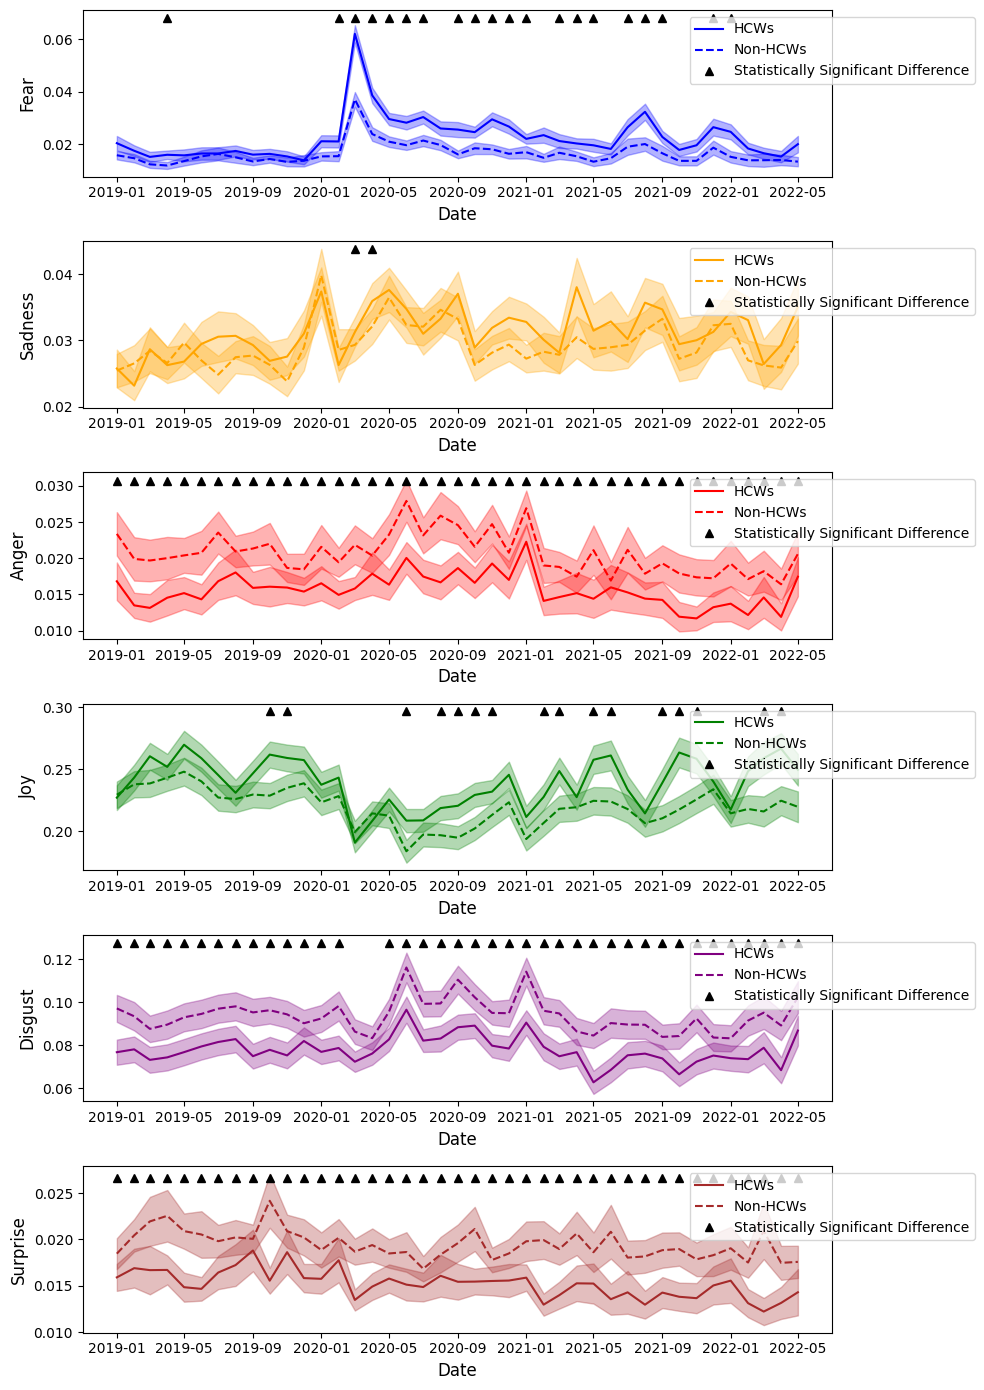

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')

# Example significant data, replace this with your actual data

# Define the emotions and colors for plotting
emotions = ['joy', 'sadness', 'anger', 'surprise', 'disgust', 'fear']
emotions = ['fear', 'sadness', 'anger', 'joy', 'disgust', 'surprise']

colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']
colors = ['blue', 'orange', 'red', 'green', 'purple', 'brown']


fig, axs = plt.subplots(len(emotions), 1, figsize=(10, 2*(len(emotions) + 1)))

for j, emotion in enumerate(emotions):
    # Convert index to datetime
    hcp_mean = grouped_hcp[f'{emotion}_mean'].reset_index()
    hcp_mean['date'] = pd.to_datetime(hcp_mean['year'].astype(int).astype(str) + '-' + hcp_mean['month'].astype(int).astype(str))
    
    general_mean = grouped_general[f'{emotion}_mean'].reset_index()
    general_mean['date'] = pd.to_datetime(general_mean['year'].astype(int).astype(str) + '-' + general_mean['month'].astype(int).astype(str))

    # Extract CI values
    hcp_ci_lower = grouped_hcp[f'{emotion}_ci_lower'].values
    hcp_ci_upper = grouped_hcp[f'{emotion}_ci_upper'].values
    general_ci_lower = grouped_general[f'{emotion}_ci_lower'].values
    general_ci_upper = grouped_general[f'{emotion}_ci_upper'].values

    # Plot the CIs and the actual trend lines
    axs[j].fill_between(hcp_mean['date'], hcp_ci_lower, hcp_ci_upper, color=colors[j], alpha=0.3)#, label='HCPs 96CI'
    axs[j].fill_between(general_mean['date'], general_ci_lower, general_ci_upper, color=colors[j], alpha=0.3) #, label='Non-Hcps 96CI'
    axs[j].plot(hcp_mean['date'], hcp_mean[f'{emotion}_mean'], color=colors[j], label='HCWs')
    axs[j].plot(general_mean['date'], general_mean[f'{emotion}_mean'], color=colors[j], linestyle='--', label='Non-HCWs')
    
    # Plot the markers for significant differences
    max_y_value_non_hcp =  general_mean[f'{emotion}_mean'].max()
    max_y_value_hcp = hcp_mean[f'{emotion}_mean'].max()
    marker_y_value = max(max_y_value_non_hcp, max_y_value_hcp) * 1.1  # Adjust factor as needed
    marker_indices = emotion_markers.get(emotion, [])
    
    for index in marker_indices:
        if index < len(hcp_mean['date']):
            axs[j].plot(hcp_mean['date'].iloc[index], marker_y_value, color='black', linestyle='', marker='^', label='Statistically Significant Difference' if index == marker_indices[0] else "")
    
    axs[j].legend(loc='upper right', bbox_to_anchor=(1.20, 1))
    axs[j].set_ylabel(f'{emotion.capitalize()}', fontsize=12)
    axs[j].set_xlabel('Date', fontsize=12)

plt.tight_layout()
plt.show()


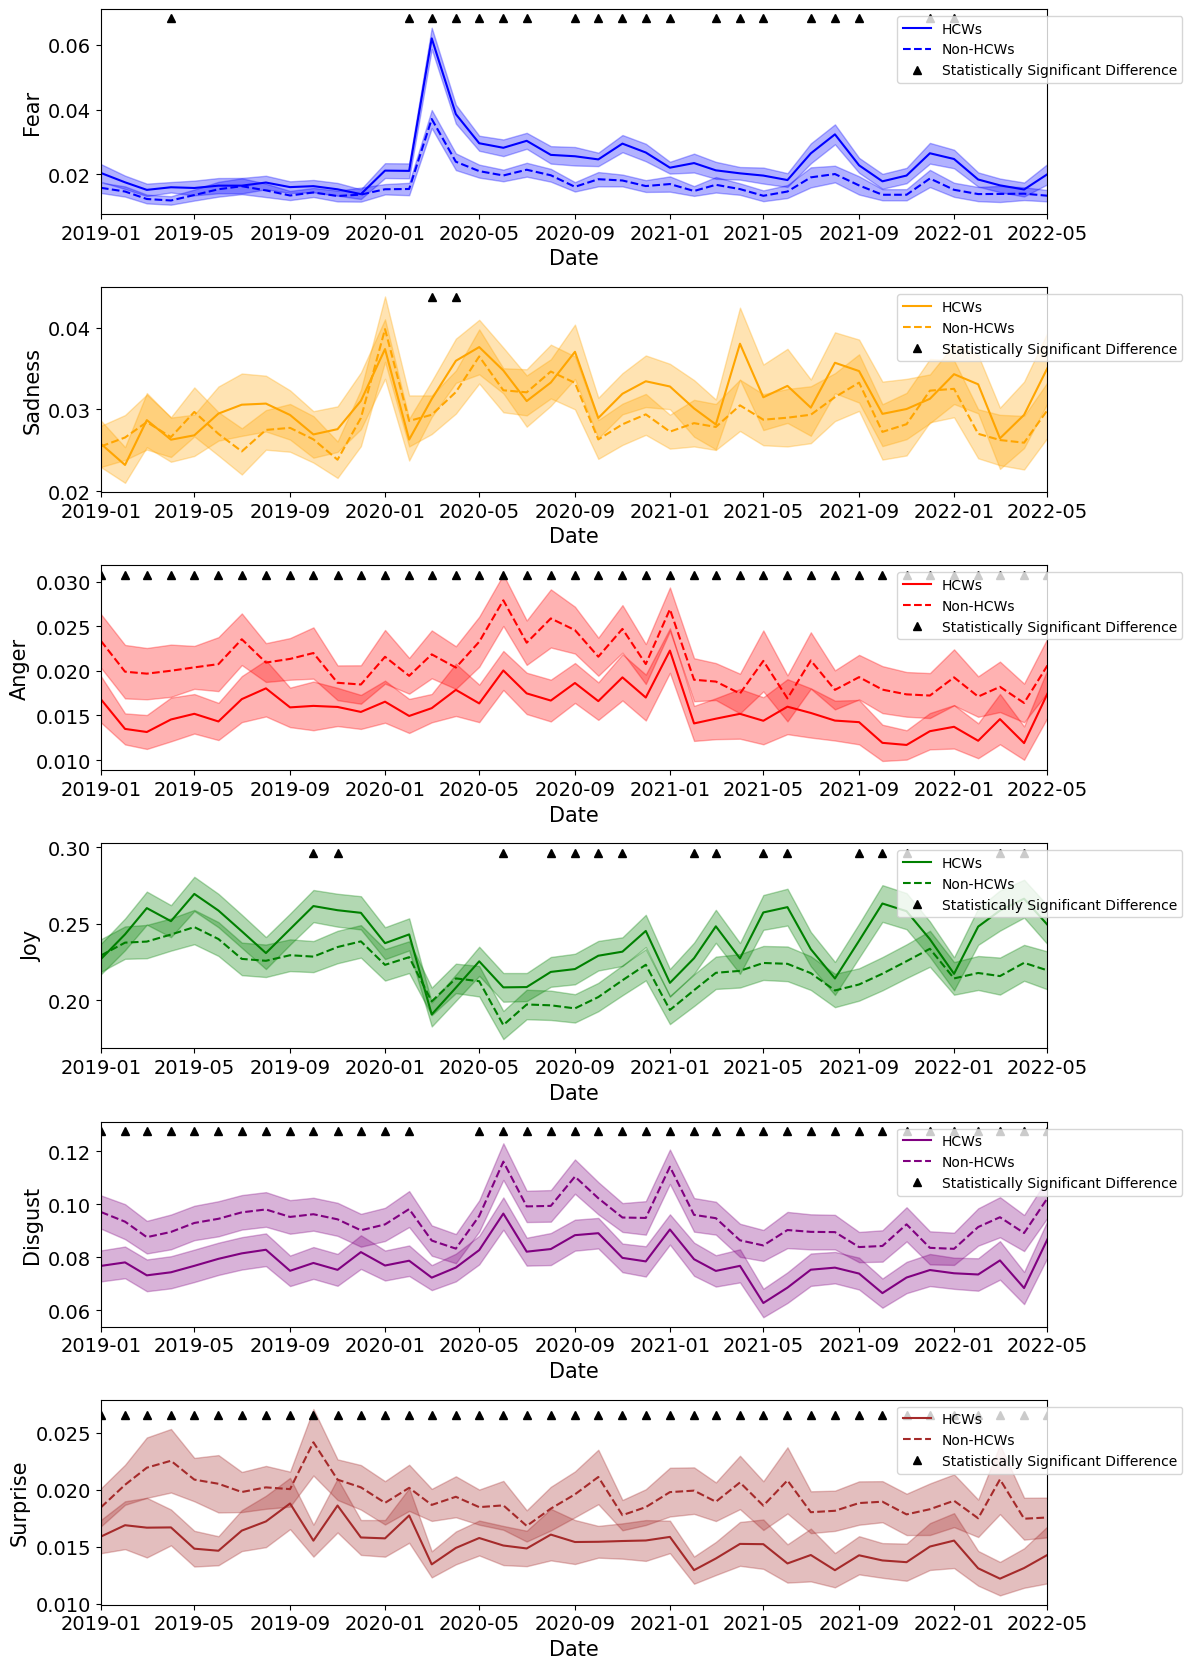

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set default plotting style
plt.style.use('default')

# --- Define emotions and corresponding colors ---
emotions = ['fear', 'sadness', 'anger', 'joy', 'disgust', 'surprise']
colors = ['blue', 'orange', 'red', 'green', 'purple', 'brown']

# --- Create subplots: one for each emotion ---
fig, axs = plt.subplots(len(emotions), 1, figsize=(12, 2.8 * len(emotions)))

for j, emotion in enumerate(emotions):
    ax = axs[j]

    # --- Prepare HCP data ---
    hcp_df = grouped_hcp[['year', 'month', f'{emotion}_mean', f'{emotion}_ci_lower', f'{emotion}_ci_upper']].copy()
    hcp_df['date'] = pd.to_datetime(hcp_df['year'].astype(str) + '-' + hcp_df['month'].astype(str))

    # --- Prepare General Population data ---
    general_df = grouped_general[['year', 'month', f'{emotion}_mean', f'{emotion}_ci_lower', f'{emotion}_ci_upper']].copy()
    general_df['date'] = pd.to_datetime(general_df['year'].astype(str) + '-' + general_df['month'].astype(str))

    # --- Plot Confidence Intervals (CI) ---
    ax.fill_between(hcp_df['date'], hcp_df[f'{emotion}_ci_lower'], hcp_df[f'{emotion}_ci_upper'],
                    color=colors[j], alpha=0.3)
    ax.fill_between(general_df['date'], general_df[f'{emotion}_ci_lower'], general_df[f'{emotion}_ci_upper'],
                    color=colors[j], alpha=0.3)

    # --- Plot Emotion Trends ---
    ax.plot(hcp_df['date'], hcp_df[f'{emotion}_mean'], color=colors[j], label='HCWs')
    ax.plot(general_df['date'], general_df[f'{emotion}_mean'], color=colors[j], linestyle='--', label='Non-HCWs')

    # --- Plot significance markers ---
    marker_indices = emotion_markers.get(emotion, [])
    if marker_indices:
        max_y = max(hcp_df[f'{emotion}_mean'].max(), general_df[f'{emotion}_mean'].max()) * 1.1
        for idx, index in enumerate(marker_indices):
            if index < len(hcp_df):
                label = 'Statistically Significant Difference' if idx == 0 else ""
                ax.plot(hcp_df['date'].iloc[index], max_y, color='black', marker='^', linestyle='', label=label)

    # --- Axis formatting ---
    ax.set_ylabel(emotion.capitalize(), fontsize=15)
    ax.set_xlabel('Date', fontsize=15)
    ax.tick_params(axis='both', labelsize=14)
    ax.set_xlim([hcp_df['date'].min(), hcp_df['date'].max()])
    ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1))

# --- Final layout and show ---
plt.tight_layout()
plt.show()


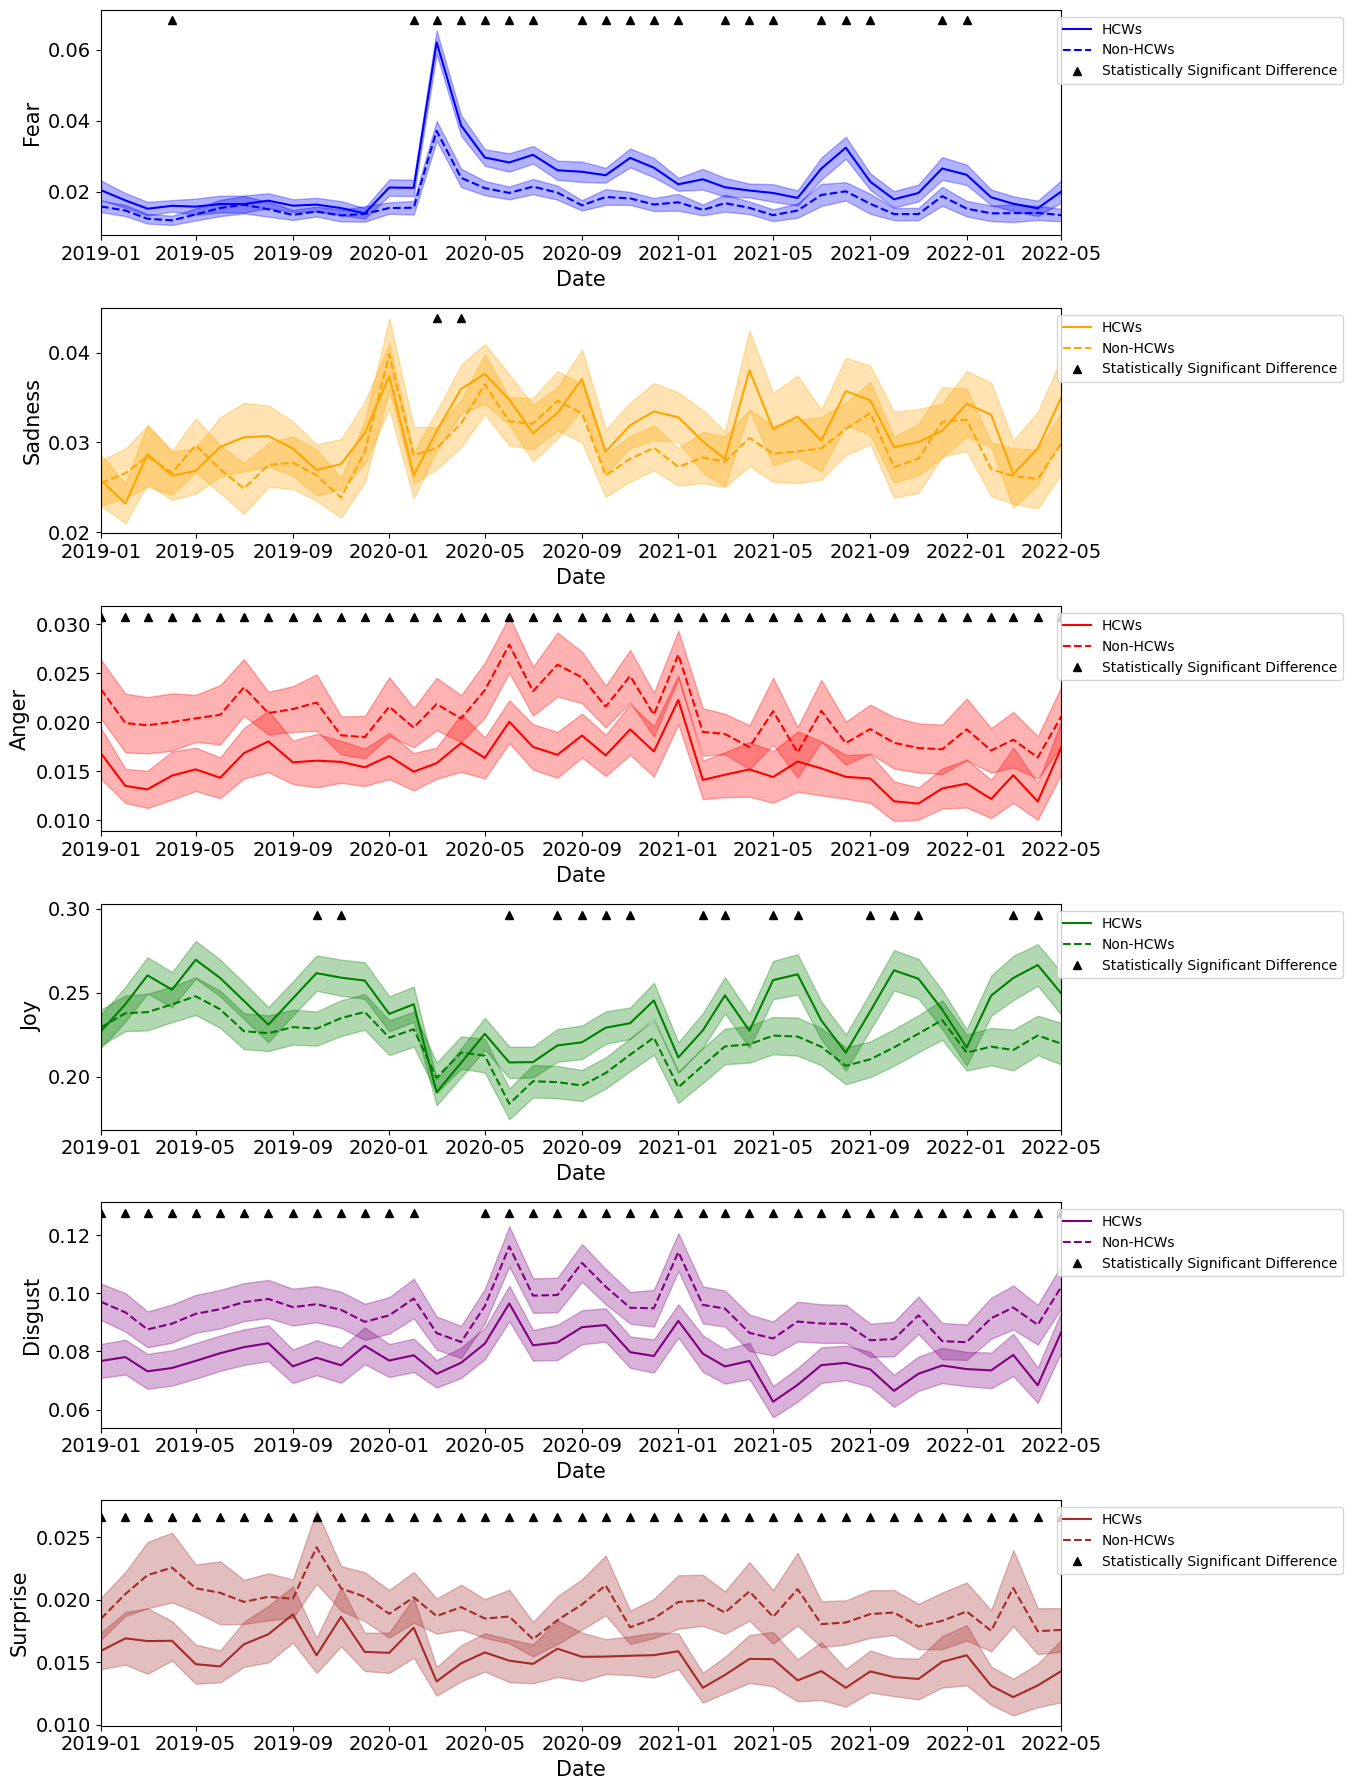

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set default plotting style
plt.style.use('default')

# --- Define emotions and colors ---
emotions = ['fear', 'sadness', 'anger', 'joy', 'disgust', 'surprise']
colors = ['blue', 'orange', 'red', 'green', 'purple', 'brown']

# --- Create subplots ---
# fig, axs = plt.subplots(len(emotions), 1, figsize=(12, 2.8 * len(emotions)))
fig, axs = plt.subplots(len(emotions), 1, figsize=(14, 3 * len(emotions)))

for j, emotion in enumerate(emotions):
    ax = axs[j]

    # --- Prepare HCP data ---
    hcp_mean = grouped_hcp[['year', 'month', f'{emotion}_mean', f'{emotion}_ci_lower', f'{emotion}_ci_upper']].copy()
    hcp_mean['date'] = pd.to_datetime(hcp_mean['year'].astype(str) + '-' + hcp_mean['month'].astype(str))

    # --- Prepare general population data ---
    general_mean = grouped_general[['year', 'month', f'{emotion}_mean', f'{emotion}_ci_lower', f'{emotion}_ci_upper']].copy()
    general_mean['date'] = pd.to_datetime(general_mean['year'].astype(str) + '-' + general_mean['month'].astype(str))

    # --- Plot confidence intervals ---
    ax.fill_between(hcp_mean['date'], hcp_mean[f'{emotion}_ci_lower'], hcp_mean[f'{emotion}_ci_upper'],
                    color=colors[j], alpha=0.3)
    ax.fill_between(general_mean['date'], general_mean[f'{emotion}_ci_lower'], general_mean[f'{emotion}_ci_upper'],
                    color=colors[j], alpha=0.3)

    # --- Plot mean lines ---
    ax.plot(hcp_mean['date'], hcp_mean[f'{emotion}_mean'], color=colors[j], label='HCWs')
    ax.plot(general_mean['date'], general_mean[f'{emotion}_mean'], color=colors[j], linestyle='--', label='Non-HCWs')

    # --- Plot significant difference markers ---
    marker_indices = emotion_markers.get(emotion, [])
    if marker_indices:
        max_y = max(hcp_mean[f'{emotion}_mean'].max(), general_mean[f'{emotion}_mean'].max()) * 1.1
        for idx, index in enumerate(marker_indices):
            if index < len(hcp_mean):
                label = 'Statistically Significant Difference' if idx == 0 else ""
                ax.plot(hcp_mean['date'].iloc[index], max_y, color='black', marker='^', linestyle='', label=label)

    # --- Axis formatting ---
    ax.set_ylabel(emotion.capitalize(), fontsize=15)
    ax.set_xlabel('Date', fontsize=15)
    ax.tick_params(axis='both', labelsize=14)
    ax.set_xlim([hcp_mean['date'].min(), hcp_mean['date'].max()])
    ax.legend(loc='upper right', bbox_to_anchor=(1.30, 1))
    # ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)


# --- Final layout ---
plt.tight_layout()
plt.show()


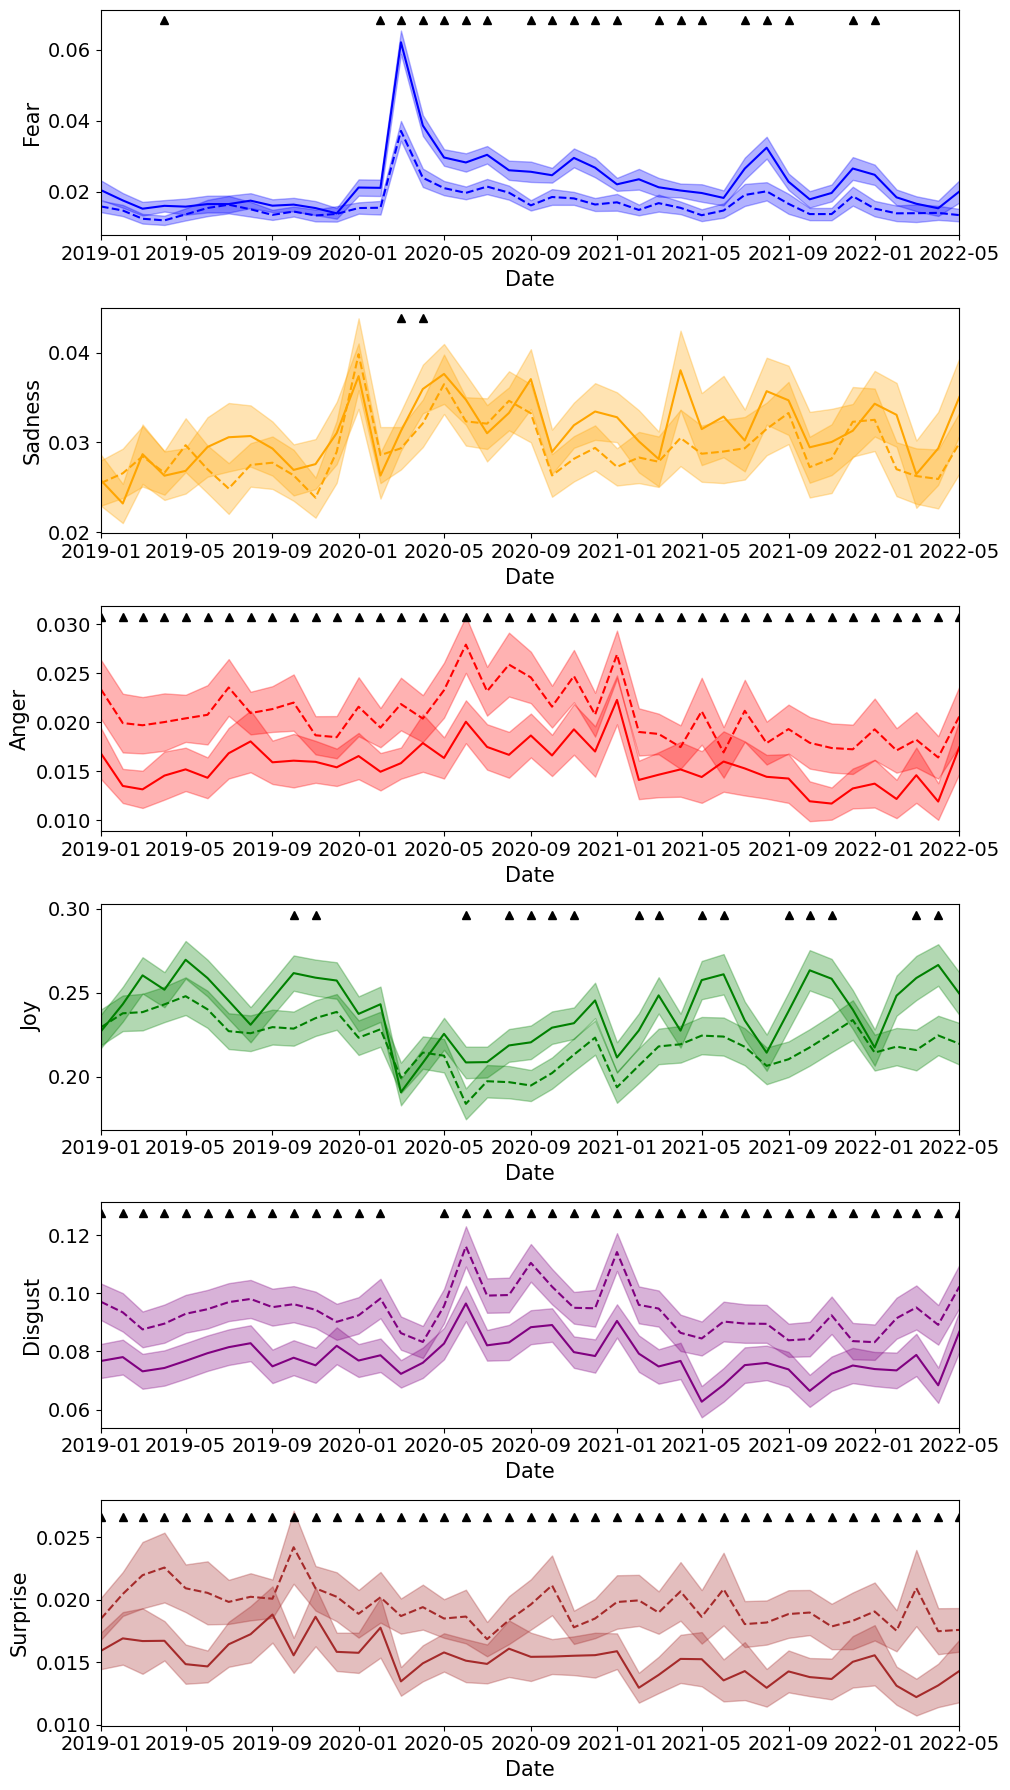

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('default')

# Define the emotions and colors for plotting
emotions = ['fear', 'sadness', 'anger', 'joy', 'disgust', 'surprise']
colors = ['blue', 'orange', 'red', 'green', 'purple', 'brown']

# Add a 'date' column once, outside the loop (if not already present)
if 'date' not in grouped_hcp.columns:
    grouped_hcp['date'] = pd.to_datetime(grouped_hcp['year'].astype(str) + '-' + grouped_hcp['month'].astype(str))

if 'date' not in grouped_general.columns:
    grouped_general['date'] = pd.to_datetime(grouped_general['year'].astype(str) + '-' + grouped_general['month'].astype(str))

# Create subplots
fig, axs = plt.subplots(len(emotions), 1, figsize=(12, 3 * len(emotions)))

for j, emotion in enumerate(emotions):
    ax = axs[j]

    # Select relevant columns for each group
    hcp_df = grouped_hcp[['date', f'{emotion}_mean', f'{emotion}_ci_lower', f'{emotion}_ci_upper']].copy()
    general_df = grouped_general[['date', f'{emotion}_mean', f'{emotion}_ci_lower', f'{emotion}_ci_upper']].copy()

    # Plot confidence intervals
    ax.fill_between(hcp_df['date'], hcp_df[f'{emotion}_ci_lower'], hcp_df[f'{emotion}_ci_upper'], color=colors[j], alpha=0.3)
    ax.fill_between(general_df['date'], general_df[f'{emotion}_ci_lower'], general_df[f'{emotion}_ci_upper'], color=colors[j], alpha=0.3)

    # Plot means
    ax.plot(hcp_df['date'], hcp_df[f'{emotion}_mean'], color=colors[j], label='HCWs')
    ax.plot(general_df['date'], general_df[f'{emotion}_mean'], color=colors[j], linestyle='--', label='Non-HCWs')

    # Plot significance markers if available
    marker_indices = emotion_markers.get(emotion, [])
    if marker_indices:
        max_y = max(hcp_df[f'{emotion}_mean'].max(), general_df[f'{emotion}_mean'].max()) * 1.1
        for idx, marker_index in enumerate(marker_indices):
            if marker_index < len(hcp_df):
                label = 'Statistically Significant Difference' if idx == 0 else ""
                ax.plot(hcp_df['date'].iloc[marker_index], max_y, color='black', marker='^', linestyle='', label=label)

    # Axis formatting
    ax.set_ylabel(emotion.capitalize(), fontsize=15)
    ax.set_xlabel('Date', fontsize=15)
    ax.tick_params(axis='both', labelsize=14)
    ax.set_xlim([hcp_df['date'].min(), hcp_df['date'].max()])
    # ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)

# Adjust layout and save figure
plt.tight_layout(rect=[0, 0, 0.85, 1])  # leave space for legend
# plt.savefig('graph/emotion_trends.png', dpi=300, bbox_inches='tight')
plt.show()


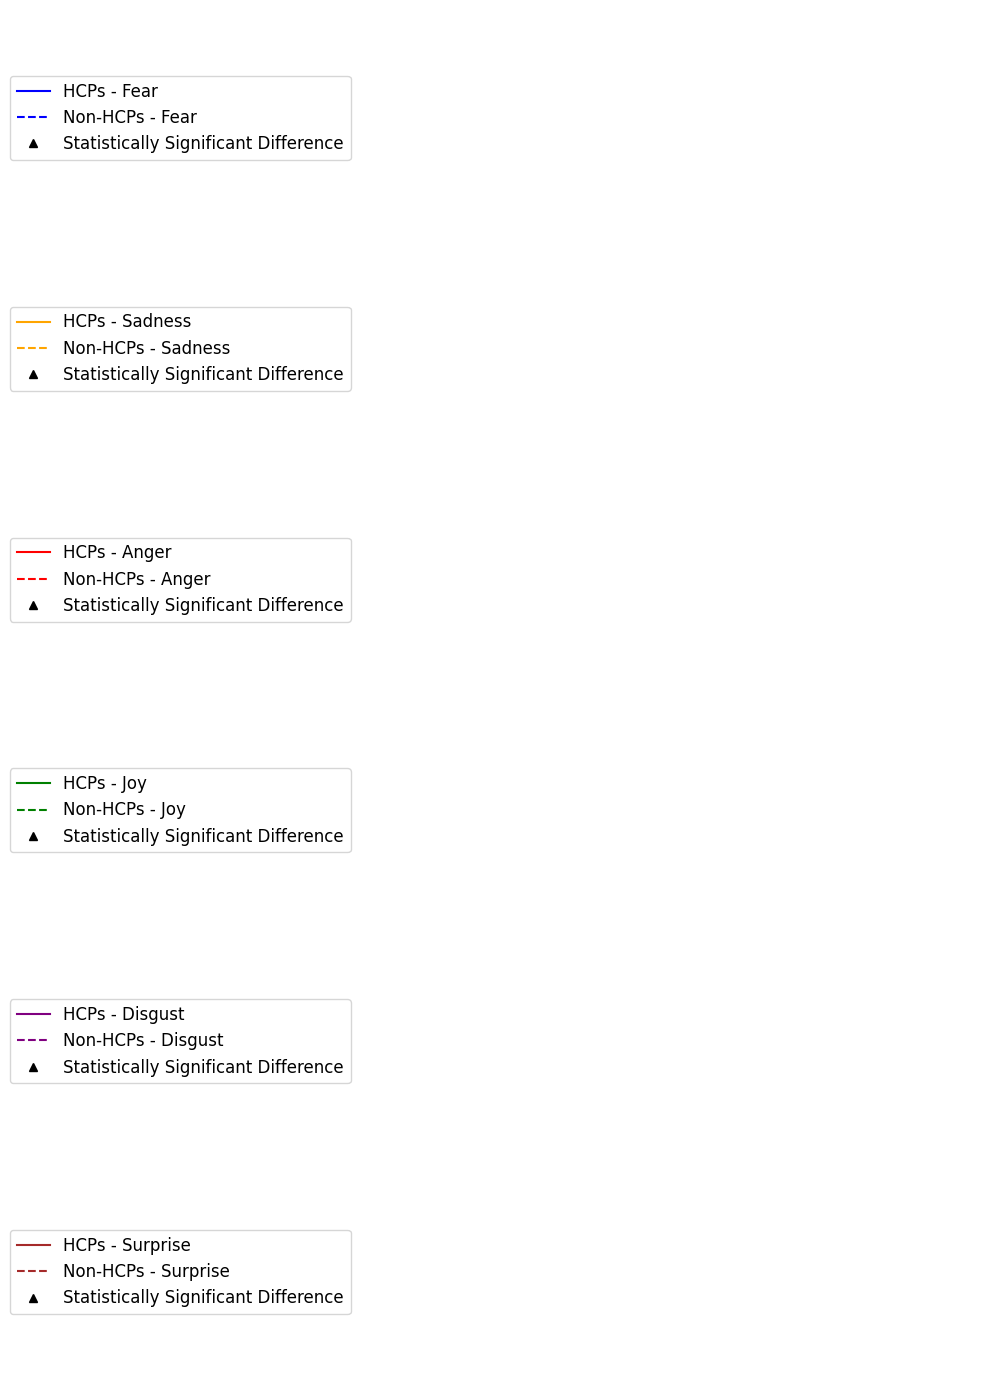

In [57]:
import matplotlib.pyplot as plt

# Define the emotions and colors for the legend
emotions = ['fear', 'sadness', 'anger', 'joy', 'disgust', 'surprise']
colors = ['blue', 'orange', 'red', 'green', 'purple', 'brown']

# Create an empty figure with subplots for each emotion
fig, axs = plt.subplots(len(emotions), 1, figsize=(10, 2*(len(emotions) + 1)))

# Generate a dummy plot for each emotion and show only the legend
for j, emotion in enumerate(emotions):
    # Create dummy plots just for the legend
    axs[j].plot([], [], color=colors[j], label=f'HCPs - {emotion.capitalize()}')
    axs[j].plot([], [], color=colors[j], linestyle='--', label=f'Non-HCPs - {emotion.capitalize()}')
    axs[j].plot([], [], color='black', linestyle='', marker='^', label='Statistically Significant Difference')

    # Show the legend for each subplot without actual plot data
    axs[j].legend(loc='center left', bbox_to_anchor=(-0.2, 0.5), fontsize=12)

    # Remove the axes to only show the legend
    axs[j].set_axis_off()

plt.tight_layout()
# plt.savefig('graph/emotion_trends_label_HCPs.png', dpi=300, bbox_inches='tight')
plt.show()


In [14]:
def calculate_df_quantile_per_tweet(df, quantile_up, quantile_low, grouped='W'):
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    
    # Select only numeric columns for quantile calculation
    numeric_df = df.select_dtypes(include=[np.number])
    
    overall_weekly_high = numeric_df.resample(grouped).quantile(quantile_up, interpolation='lower')
    overall_weekly_low = numeric_df.resample(grouped).quantile(quantile_low, interpolation='lower')
    overall_weekly_avg = numeric_df.resample(grouped).mean()
    overall_weekly_std = numeric_df.resample(grouped).std()
    overall_weekly_median = numeric_df.resample(grouped).median()
    overall_weekly_median.columns = ['median_' + col for col in overall_weekly_median.columns]

    
    # Rename the columns in each DataFrame to have unique names
    overall_weekly_high.columns = ['high_' + col for col in overall_weekly_high.columns]
    overall_weekly_low.columns = ['low_' + col for col in overall_weekly_low.columns]
    overall_weekly_avg.columns = ['avg_' + col for col in overall_weekly_avg.columns]
    overall_weekly_std.columns = ['std_' + col for col in overall_weekly_avg.columns]

    # Now concatenate them
    overall_weekly_stats = pd.concat([overall_weekly_high, overall_weekly_low, overall_weekly_avg, overall_weekly_median, overall_weekly_std], axis=1)
    return overall_weekly_stats

overall_weekly_stats_g = calculate_df_quantile_per_tweet(general_avg_user, 0.75, 0.25, 'M')#0.30, 0.20


/tmp/ipykernel_1508739/1322026105.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  overall_weekly_high = numeric_df.resample(grouped).quantile(quantile_up, interpolation='lower')
/tmp/ipykernel_1508739/1322026105.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  overall_weekly_low = numeric_df.resample(grouped).quantile(quantile_low, interpolation='lower')
/tmp/ipykernel_1508739/1322026105.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  overall_weekly_avg = numeric_df.resample(grouped).mean()
/tmp/ipykernel_1508739/1322026105.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  overall_weekly_std = numeric_df.resample(grouped).std()
/tmp/ipykernel_1508739/1322026105.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME

#calculate p value

In [17]:




hcp_avg_user = final_h.groupby('screen_name').resample('M').mean()
general_avg_user = final_df.groupby('screen_name').resample('M').mean()
hcp_avg_user = hcp_avg_user.reset_index()
general_avg_user = general_avg_user.reset_index()



/tmp/ipykernel_1508739/3239723952.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  hcp_avg_user = final_h.groupby('screen_name').resample('M').mean()
/tmp/ipykernel_1508739/3239723952.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  general_avg_user = final_df.groupby('screen_name').resample('M').mean()


In [21]:
import scipy.stats as stats
import pandas as pd
from statsmodels.sandbox.stats.multicomp import multipletests

emotions = {'joy':[], 'sadness':[], 'anger':[], 'surprise':[], 'disgust':[], 'fear':[]}
date_idx= overall_weekly_stats_g.index.tolist()
p_values = []
tests_used = []

alpha = 0.05/len(date_idx)

for emotion in emotions.keys():
    for date_id in date_idx:
        # Filter data for each emotion and each population
        data1 = hcp_avg_user[hcp_avg_user['date'] == date_id][emotion].dropna().tolist()
        data2 = general_avg_user[general_avg_user['date'] == date_id][emotion].dropna().tolist()
        

        # Check normality
        _, p1 = stats.shapiro(data1)
        _, p2 = stats.shapiro(data2)

        if p1 > 0.05 and p2 > 0.05:  # both samples are normally distributed
            _, p_value = stats.ttest_ind(data1, data2)
            test_used = 'Independent t-test'
        else:  # use non-parametric test
            _, p_value = stats.mannwhitneyu(data1, data2)
            test_used = 'Mann-Whitney U Test'
        result = p_value<alpha
        emotions[emotion].append([result,p_value,test_used])
        p_values.append(p_value)
        tests_used.append(test_used)

# Calculate the number of tests
# number_of_tests =len(date_idx)

# # Correct for multiple comparisons using the Bonferroni method
# corrected_p_values = multipletests(p_values, alpha=0.05 / number_of_tests, method='bonferroni')[1]

# # Interpret the results
# for emotion, test, p_value in zip(emotions, tests_used, corrected_p_values):
#     if p_value < (0.05 / number_of_tests):  # Use the Bonferroni-adjusted alpha level
#         print(f"There is a significant difference in {emotion} between the two populations (Test: {test}, p={p_value})")
#     else:
#         print(f"There is no significant difference in {emotion} between the two populations (Test: {test}, p={p_value:.4f})")

In [22]:
emotions

{'joy': [[False, 0.6174676507385572, 'Mann-Whitney U Test'],
  [False, 0.3876292540101659, 'Mann-Whitney U Test'],
  [False, 0.0013016238161399354, 'Mann-Whitney U Test'],
  [False, 0.20460045243769687, 'Mann-Whitney U Test'],
  [False, 0.0017902202939699694, 'Mann-Whitney U Test'],
  [False, 0.0041342219812028685, 'Mann-Whitney U Test'],
  [False, 0.011880197065724987, 'Mann-Whitney U Test'],
  [False, 0.34224113472186124, 'Mann-Whitney U Test'],
  [False, 0.004613182940230342, 'Mann-Whitney U Test'],
  [True, 3.136717722251174e-06, 'Mann-Whitney U Test'],
  [True, 0.0005619320478794728, 'Mann-Whitney U Test'],
  [False, 0.015508581982709406, 'Mann-Whitney U Test'],
  [False, 0.05220453398281429, 'Mann-Whitney U Test'],
  [False, 0.03305981605104687, 'Mann-Whitney U Test'],
  [False, 0.9565235262233137, 'Mann-Whitney U Test'],
  [False, 0.9354198135105823, 'Mann-Whitney U Test'],
  [False, 0.007875234691110006, 'Mann-Whitney U Test'],
  [True, 2.413480077401215e-05, 'Mann-Whitney U Te

In [28]:
# Prepare data for DataFrame
rows = []
dates_lst = [ i - pd.offsets.MonthEnd(1) + pd.DateOffset(days=1) for i in date_idx]
for emotion, values in emotions.items():
    idx = 0
    for value in values:
        date = dates_lst[idx]
        result, p_value, test_used = value
        rows.append({"Emotion": emotion, "Result": result, "P-value": p_value, "Test Used": test_used,"Dates":date})
        idx+=1

# Convert to DataFrame
df = pd.DataFrame(rows)

# Save to Excel
df.to_excel("emotions_results_p_value.xlsx", index=False)
